## Finalizing Bldg Permit Data for Creating Visualizations
- Discovered when starting to create visualizations that I needed one cleaned dataset with **both** types of permits Applications and Permits; and I only needed *some* of the cleaning steps used in the prior notebooks, and in a different sequence than they had been applied. I may need those steps later, so I'm leaving those notebooks intact.
- SOLUTION: Creating new notebook 3_finalize_data and will only do the steps needed to get final, single dataset.
- NAMING: To differentiatl these two bldg. permit dfs from prior notebooks, using these names:
    - df1_applic (permit applications)  
    - df2_issued (permits issued)  
    - df3_applic_and_issued (merged file for mapping)  
- PREPARE
    1. Column name cleanup
    2. Data types cleanup
    3. New column: 'category' (Residential, Commercial, Other)
    4. New column: 'type_subtype' concatenation
    5. Drop addresses with "0" house number
    6. Pull lat/lon from mapped_location
    7. Drop rows with null lat/lon
    8. Sort by address (prerequsite to dropping duplicates)
    9. Drop duplicates:  Unable to do this. Will come back to it after internal walkthrough.
    10. Convert to geodataframe
    11. Keep only addresses within Davidson County
    12. Add Neighborhood Association names
    13. Merge
    14. Export

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd   # Prerequisite: Anotes_and_docsctivate geospatial environment via Conda Prompt
import matplotlib.pyplot as plt  
import folium                   
from folium.plugins import MarkerCluster
import datetime
from shapely.geometry import Point  
import re # To use RegEx to pull ot lat/long from building permit applications/issued

## Reading in raw data for permits, and cleaned data for polygon files (N. Assoc and Davidson County)

In [2]:
# Building Dept. Permit Applications

df1_applic = pd.read_csv('../data/raw/Building_Permit_Applications_2020_06_05.csv')
df1_applic.head(2)

,Permit #,Permit Type Description,Permit Subtype Description,Parcel,Date Entered,Date Issued,Construction Cost,Address,City,State,ZIP,Subdivision / Lot,Contact,Permit Type,Permit Subtype,IVR Tracking #,Purpose,Council District,Mapped Location
0,T2020016213,Building Residential - New,Single Family Residence,10216006100,03/11/2020,NaN,NaN,748 DARDEN PL,NASHVILLE,TN,37205,LOT 168 SEC 9 PT 2 HILLWOOD EST,Kingdom Builders of Tennesse,CARN,CAA01R301,3781725,New Single family dwelling. REJECTED: APPLICA...,23.0,"748 DARDEN PL\nNASHVILLE, TN 37205\n(36.125944..."
1,T2019073204,Building Moving Permit,Moving Permit - Residential,04600002700,12/02/2019,NaN,2500.0,4836 BULL RUN RD,ASHLAND CITY,TN,37015,N OF BULL RUN RD W OF OLD HICKORY BLVD,CLAYTON HOMES #054,CAMV,CAZ09A001,3736813,Move existing mobile home from property out of...,1.0,"4836 BULL RUN RD\nASHLAND CITY, TN 37015\n(36...."


In [3]:
df1_applic.shape

(3106, 19)

In [4]:
# Building Dept. Permits Issued
# low_memory = False was added to remove a low-memory warning. Doing this prevents the
# system from trying to assign dtypes until after the full file has been read
# Resource: https://tinyurl.com/stackoverflow-low-memory

df2_issued = pd.read_csv('../data/raw/Building_Permits_Issued_2020_06_05.csv'
                        , low_memory=False
                        )
df2_issued.head(2)

,Permit #,Permit Type Description,Permit Subtype Description,Parcel,Date Entered,Date Issued,Construction Cost,Address,City,State,ZIP,Subdivision / Lot,Contact,Permit Type,Permit Subtype,IVR Tracking #,Purpose,Council District,Census Tract,Mapped Location
0,2019070460,Building Residential - New,Single Family Residence,058100C04900CO,11/18/2019,12/09/2019,270585.0,1037 LAWSONS RIDGE DR,NASHVILLE,TN,37218,LOT 49 CARRINGTON PLACE PH 5,CELEBRATION HOMES LLC,CARN,CAA01R301,3733056,To construct a single family residence of 2402...,1.0,37010105.0,"1037 LAWSONS RIDGE DR\nNASHVILLE, TN 37218"
1,2020016259,Building Residential - Rehab,Single Family Residence,160150A07000CO,03/12/2020,03/12/2020,12000.0,210 HEARTHSTONE MANOR LN,BRENTWOOD,TN,37027,UNIT 70 HEARTHSTONE MANOR CONDOMINIUM PHASE 4,ACCESS & MOBILITY INC,CARR,CAA01R301,3781961,to install a new elevator/platform lift from g...,4.0,37018803.0,"210 HEARTHSTONE MANOR LN\nBRENTWOOD, TN 37027\..."


In [5]:
df2_issued.shape

(33909, 20)

In [6]:
# NEIGHBORHOOD ASSOCIATION BOUNDARIES
# Expecting: 288 rows, 2 columns

df_na_bound_clean = gpd.read_file('../data/cleaned/neighborhood_association_boundaries_clean.shp')
print(df_na_bound_clean.shape)
df_na_bound_clean.head(2)

(288, 2)


,name,geometry
0,Historic Buena Vista,"POLYGON ((-86.79511 36.17576, -86.79403 36.176..."
1,Charlotte Park,"POLYGON ((-86.87460 36.15758, -86.87317 36.157..."


In [7]:
# DAVIDSON COUNTY BORDER GeoJSON folder

df_dav_border = gpd.read_file('../data/raw/Davidson County Border (GIS).geojson')
print(df_dav_border.shape)
df_dav_border.head(2)

(2, 5)


,area_sq_mi,objectid,shape_area,shape_len,geometry
0,525,4,14641027913.6,686109.334953,"MULTIPOLYGON (((-86.52704 36.13598, -86.52914 ..."
1,0,3,675823.52,3786.70930403,"MULTIPOLYGON (((-86.52315 36.13876, -86.52288 ..."


## 1. Column name cleanup

In [8]:
# PERMIT APPLICATIONS

df1_applic.columns

Index(['Permit #', 'Permit Type Description', 'Permit Subtype Description',
       'Parcel', 'Date Entered', 'Date Issued', 'Construction Cost', 'Address',
       'City', 'State', 'ZIP', 'Subdivision / Lot', 'Contact', 'Permit Type',
       'Permit Subtype', 'IVR Tracking #', 'Purpose', 'Council District',
       'Mapped Location'],
      dtype='object')

In [9]:
df1_applic.columns = (df1_applic.columns
                      .str.replace(" ", "_")
                      .str.replace("/", "_")
                      .str.replace("Description", "descr")
                      .str.replace("#", "number")
                      .str.replace("___", "_")
                      .str.lower())
df1_applic.head(2)

,permit_number,permit_type_descr,permit_subtype_descr,parcel,date_entered,date_issued,construction_cost,address,city,state,zip,subdivision_lot,contact,permit_type,permit_subtype,ivr_tracking_number,purpose,council_district,mapped_location
0,T2020016213,Building Residential - New,Single Family Residence,10216006100,03/11/2020,NaN,NaN,748 DARDEN PL,NASHVILLE,TN,37205,LOT 168 SEC 9 PT 2 HILLWOOD EST,Kingdom Builders of Tennesse,CARN,CAA01R301,3781725,New Single family dwelling. REJECTED: APPLICA...,23.0,"748 DARDEN PL\nNASHVILLE, TN 37205\n(36.125944..."
1,T2019073204,Building Moving Permit,Moving Permit - Residential,04600002700,12/02/2019,NaN,2500.0,4836 BULL RUN RD,ASHLAND CITY,TN,37015,N OF BULL RUN RD W OF OLD HICKORY BLVD,CLAYTON HOMES #054,CAMV,CAZ09A001,3736813,Move existing mobile home from property out of...,1.0,"4836 BULL RUN RD\nASHLAND CITY, TN 37015\n(36...."


In [10]:
# PERMITS ISSUED

df2_issued.columns = (df2_issued.columns
                      .str.replace(" ", "_")
                      .str.replace("/", "_")
                      .str.replace("Description", "descr")
                      .str.replace("#", "number")
                      .str.replace("___", "_")
                      .str.lower())
df2_issued.head(2)

,permit_number,permit_type_descr,permit_subtype_descr,parcel,date_entered,date_issued,construction_cost,address,city,state,zip,subdivision_lot,contact,permit_type,permit_subtype,ivr_tracking_number,purpose,council_district,census_tract,mapped_location
0,2019070460,Building Residential - New,Single Family Residence,058100C04900CO,11/18/2019,12/09/2019,270585.0,1037 LAWSONS RIDGE DR,NASHVILLE,TN,37218,LOT 49 CARRINGTON PLACE PH 5,CELEBRATION HOMES LLC,CARN,CAA01R301,3733056,To construct a single family residence of 2402...,1.0,37010105.0,"1037 LAWSONS RIDGE DR\nNASHVILLE, TN 37218"
1,2020016259,Building Residential - Rehab,Single Family Residence,160150A07000CO,03/12/2020,03/12/2020,12000.0,210 HEARTHSTONE MANOR LN,BRENTWOOD,TN,37027,UNIT 70 HEARTHSTONE MANOR CONDOMINIUM PHASE 4,ACCESS & MOBILITY INC,CARR,CAA01R301,3781961,to install a new elevator/platform lift from g...,4.0,37018803.0,"210 HEARTHSTONE MANOR LN\nBRENTWOOD, TN 37027\..."


## 2a. Data types cleanup - Permit Applications

In [11]:
# PERMIT APPLICATIONS
# Confirming dtypes
# NEED TO CHANGE: date_entered should be datetime fields

df1_applic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3106 entries, 0 to 3105
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   permit_number         3106 non-null   object 
 1   permit_type_descr     3106 non-null   object 
 2   permit_subtype_descr  3106 non-null   object 
 3   parcel                3106 non-null   object 
 4   date_entered          3106 non-null   object 
 5   date_issued           0 non-null      float64
 6   construction_cost     1651 non-null   float64
 7   address               3106 non-null   object 
 8   city                  3106 non-null   object 
 9   state                 3106 non-null   object 
 10  zip                   3106 non-null   int64  
 11  subdivision_lot       3105 non-null   object 
 12  contact               3105 non-null   object 
 13  permit_type           3106 non-null   object 
 14  permit_subtype        3106 non-null   object 
 15  ivr_tracking_number  

In [12]:
# Convert date_entered to datetime 
#  (tried using .dt.date to keep date, only, but that changed it back into object dtype)
# .dt.date causes only the date to show

df1_applic.date_entered = pd.to_datetime(df1_applic.date_entered)
df1_applic.date_entered.head(2)

0   2020-03-11
1   2019-12-02
Name: date_entered, dtype: datetime64[ns]

In [13]:
# Double-checking min/max dates in this df

print(df1_applic.date_entered.min())
print(df1_applic.date_entered.max())

2017-06-01 00:00:00
2020-06-04 00:00:00


## 2b. Data types cleanup - Permits Issued

In [14]:
# PERMITS ISSUED
# Confirming dtypes
# NEED TO CHANGE: date_entered should be datetime field

df2_issued.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33909 entries, 0 to 33908
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   permit_number         33909 non-null  object 
 1   permit_type_descr     33909 non-null  object 
 2   permit_subtype_descr  33909 non-null  object 
 3   parcel                33909 non-null  object 
 4   date_entered          33909 non-null  object 
 5   date_issued           33909 non-null  object 
 6   construction_cost     33899 non-null  float64
 7   address               33909 non-null  object 
 8   city                  33909 non-null  object 
 9   state                 33909 non-null  object 
 10  zip                   33909 non-null  int64  
 11  subdivision_lot       33909 non-null  object 
 12  contact               33908 non-null  object 
 13  permit_type           33909 non-null  object 
 14  permit_subtype        33909 non-null  object 
 15  ivr_tracking_number

In [15]:
# Convert date_entered to datetime

df2_issued.date_entered = pd.to_datetime(df2_issued.date_entered)
df2_issued.date_entered.head(2)

0   2019-11-18
1   2020-03-12
Name: date_entered, dtype: datetime64[ns]

In [16]:
# Convert date_issued to datetime

df2_issued.date_issued = pd.to_datetime(df2_issued.date_issued)
df2_issued.date_issued.head(2)

0   2019-12-09
1   2020-03-12
Name: date_issued, dtype: datetime64[ns]

In [17]:
# Double-checking min/max dates in this df

print(df2_issued.date_issued.min())
print(df2_issued.date_issued.max())

2017-06-01 00:00:00
2020-06-04 00:00:00


## 3. New column: 'category' (Residential, Commercial, Other)

In [18]:
# Building Permit Applications df
# Stackoverflow resource: https://stackoverflow.com/questions/36653419/str-contains-to-create-new-column-in-pandas-dataframe

# Set a default value for new category column
df1_applic['category'] = 'Other'

# Assign Commercial, Residential based on permit_type AND permit_subtype, to capture the most possible of each one
# Doing BOTH type and sub_type increased Commercial category the most
df1_applic.loc[df1_applic['permit_type_descr'].str.contains('Commercial'), 'category'] = 'Commercial'
df1_applic.loc[df1_applic['permit_subtype_descr'].str.contains('Commercial'), 'category'] = 'Commercial'

df1_applic.loc[df1_applic['permit_type_descr'].str.contains('Residential'), 'category'] = 'Residential'
df1_applic.loc[df1_applic['permit_subtype_descr'].str.contains('Residential'), 'category'] = 'Residential'

print(df1_applic['category'].value_counts())
print(df1_applic.shape)

Residential    2204
Commercial      458
Other           444
Name: category, dtype: int64
(3106, 20)


In [19]:
# Building Permits Issued df
# Stackoverflow resource: https://stackoverflow.com/questions/36653419/str-contains-to-create-new-column-in-pandas-dataframe

# Set a default value for new category column
df2_issued['category'] = 'Other'

# Assign Commercial, Residential based on permit_type AND permit_subtype, to capture the most possible of each one
# Doing BOTH type and sub_type increased Commercial category the most
df2_issued.loc[df2_issued['permit_type_descr'].str.contains('Commercial'), 'category'] = 'Commercial'
df2_issued.loc[df2_issued['permit_subtype_descr'].str.contains('Commercial'), 'category'] = 'Commercial'

df2_issued.loc[df2_issued['permit_type_descr'].str.contains('Residential'), 'category'] = 'Residential'
df2_issued.loc[df2_issued['permit_subtype_descr'].str.contains('Residential'), 'category'] = 'Residential'

print(df2_issued['category'].value_counts())
print(df2_issued.shape)

Residential    22893
Commercial      7029
Other           3987
Name: category, dtype: int64
(33909, 21)


## 4. New column: 'type_subtype' concatenation

In [20]:
# BLDG PERMIT APPLICATIONS
# For use in Tableau visualization

df1_applic['type_subtype'] = ("TYPE: "
                              + df1_applic['permit_type_descr']
                              + " SUBTYPE: " 
                              + df1_applic['permit_subtype_descr']
                             )
df1_applic.head(1)     

,permit_number,permit_type_descr,permit_subtype_descr,parcel,date_entered,date_issued,construction_cost,address,city,state,...,subdivision_lot,contact,permit_type,permit_subtype,ivr_tracking_number,purpose,council_district,mapped_location,category,type_subtype
0,T2020016213,Building Residential - New,Single Family Residence,10216006100,2020-03-11,NaN,NaN,748 DARDEN PL,NASHVILLE,TN,...,LOT 168 SEC 9 PT 2 HILLWOOD EST,Kingdom Builders of Tennesse,CARN,CAA01R301,3781725,New Single family dwelling. REJECTED: APPLICA...,23.0,"748 DARDEN PL\nNASHVILLE, TN 37205\n(36.125944...",Residential,TYPE: Building Residential - New SUBTYPE: Sing...


In [21]:
# BLDG PERMITS ISSUED

df2_issued['type_subtype'] = ("TYPE: "
                              + df2_issued['permit_type_descr'] 
                              + " SUBTYPE: "
                              + df2_issued['permit_subtype_descr']
                             )
df2_issued.head(1)

,permit_number,permit_type_descr,permit_subtype_descr,parcel,date_entered,date_issued,construction_cost,address,city,state,...,contact,permit_type,permit_subtype,ivr_tracking_number,purpose,council_district,census_tract,mapped_location,category,type_subtype
0,2019070460,Building Residential - New,Single Family Residence,058100C04900CO,2019-11-18,2019-12-09,270585.0,1037 LAWSONS RIDGE DR,NASHVILLE,TN,...,CELEBRATION HOMES LLC,CARN,CAA01R301,3733056,To construct a single family residence of 2402...,1.0,37010105.0,"1037 LAWSONS RIDGE DR\nNASHVILLE, TN 37218",Residential,TYPE: Building Residential - New SUBTYPE: Sing...


## 5. Drop addresses with "0" house number

In [22]:
# Finding addresses that start with '0' house number

#df1_applic.loc[df1_applic['address'].str.startswith('0')]

# RESULT: 10 rows

In [23]:
# Building Permit Applications - Keeping all rows that DON'T have "0" for house number
# Original dataset 3106 rows. 
# After change, should be 3106 - 10 = 3096 rows  CONFIRMED

df1_applic = df1_applic[~df1_applic.address.str.startswith('0')]  # tilda means take everything EXECPT
df1_applic.shape 

(3096, 21)

In [24]:
# Finding addresses that start with '0' house number

#df2_issued.loc[df2_issued['address'].str.startswith('0')]

# RESULT: 40 rows

In [25]:
# Building Permits Isued - Keeping all rows that DON'T have "0" for house number
# Original dataset 3106 rows. After change, should be 33909 - 40 =  33869

df2_issued = df2_issued[~df2_issued.address.str.startswith('0')]  # tilda means take everything EXECPT
df2_issued.shape 

(33869, 22)

## 6. Pull lat/lon from mapped_location

In [26]:
# Building Permit Applications

df1_applic.mapped_location.unique()

array(['748 DARDEN PL\nNASHVILLE, TN 37205\n(36.125944, -86.879062)',
       '4836 BULL RUN RD\nASHLAND CITY, TN 37015\n(36.242681, -86.929594)',
       '4119 MURFREESBORO PIKE\nANTIOCH, TN 37013\n(36.032211, -86.594799)',
       ...,
       '6680 CHARLOTTE PIKE B-5\nNASHVILLE, TN 37209\n(36.136609, -86.883701)',
       '3805 CHARLOTTE AVE\nNASHVILLE, TN 37209\n(36.152561, -86.831473)',
       '5610A GRANNY WHITE PIKE\nBRENTWOOD, TN 37027\n(36.046438, -86.815953)'],
      dtype=object)

In [27]:
# To pull out lat/lng from mapped_location using regex / Regular Expression
# RegEx link:  https://regex101.com/r/cAI6sh/1

pattern = re.compile(r'.*\((\d*\S\d*)\S\s(\S\d*\S\d*)\)', flags = re.MULTILINE)

def extract_lat_lon(map_loc):
    '''To extract lat/lon from mapped_location
    in both bldg permit files'''
    try:
        lat_lon_match = pattern.search(map_loc)
        lat = float(lat_lon_match.group(1))
        lon = float(lat_lon_match.group(2))
        return(lat, lon)
    except:
        return(np.NaN, np.NaN)

In [28]:
# BLDG PERMIT APPLICATIONS
# Create list comprehension

lat_lon = [extract_lat_lon(map_loc) for map_loc in df1_applic.mapped_location]  #list comprehension

In [29]:
# Extract lat

df1_applic['lat'] = [lat for lat, lon in lat_lon]

In [30]:
# Extract lon

df1_applic['lon'] = [lon for lat, lon in lat_lon]

In [31]:
df1_applic.head(2)

,permit_number,permit_type_descr,permit_subtype_descr,parcel,date_entered,date_issued,construction_cost,address,city,state,...,permit_type,permit_subtype,ivr_tracking_number,purpose,council_district,mapped_location,category,type_subtype,lat,lon
0,T2020016213,Building Residential - New,Single Family Residence,10216006100,2020-03-11,NaN,NaN,748 DARDEN PL,NASHVILLE,TN,...,CARN,CAA01R301,3781725,New Single family dwelling. REJECTED: APPLICA...,23.0,"748 DARDEN PL\nNASHVILLE, TN 37205\n(36.125944...",Residential,TYPE: Building Residential - New SUBTYPE: Sing...,36.125944,-86.879062
1,T2019073204,Building Moving Permit,Moving Permit - Residential,04600002700,2019-12-02,NaN,2500.0,4836 BULL RUN RD,ASHLAND CITY,TN,...,CAMV,CAZ09A001,3736813,Move existing mobile home from property out of...,1.0,"4836 BULL RUN RD\nASHLAND CITY, TN 37015\n(36....",Residential,TYPE: Building Moving Permit SUBTYPE: Moving P...,36.242681,-86.929594


In [32]:
# BLDG PERMITS ISSUED
# Create list comprehension

lat_lon = [extract_lat_lon(map_loc) for map_loc in df2_issued.mapped_location]  #list comprehension

In [33]:
# Extract lat
# Warning is okay. 

df2_issued['lat'] = [lat for lat, lon in lat_lon]

In [34]:
# Extract lon
# Warning is okay. 

df2_issued['lon'] = [lon for lat, lon in lat_lon]

In [35]:
df2_issued.head(2)

,permit_number,permit_type_descr,permit_subtype_descr,parcel,date_entered,date_issued,construction_cost,address,city,state,...,permit_subtype,ivr_tracking_number,purpose,council_district,census_tract,mapped_location,category,type_subtype,lat,lon
0,2019070460,Building Residential - New,Single Family Residence,058100C04900CO,2019-11-18,2019-12-09,270585.0,1037 LAWSONS RIDGE DR,NASHVILLE,TN,...,CAA01R301,3733056,To construct a single family residence of 2402...,1.0,37010105.0,"1037 LAWSONS RIDGE DR\nNASHVILLE, TN 37218",Residential,TYPE: Building Residential - New SUBTYPE: Sing...,NaN,NaN
1,2020016259,Building Residential - Rehab,Single Family Residence,160150A07000CO,2020-03-12,2020-03-12,12000.0,210 HEARTHSTONE MANOR LN,BRENTWOOD,TN,...,CAA01R301,3781961,to install a new elevator/platform lift from g...,4.0,37018803.0,"210 HEARTHSTONE MANOR LN\nBRENTWOOD, TN 37027\...",Residential,TYPE: Building Residential - Rehab SUBTYPE: Si...,36.042219,-86.764816


## 7. Drop rows with null lat/lon

In [36]:
# BLDG PERMIT APPLICATIONS
# Find out how many of the mapped locations had only the address, not the lat/lon
# Number of rows missing lat & lon:  289

print(df1_applic.shape)
print(df1_applic.isnull().sum())

(3096, 23)
permit_number              0
permit_type_descr          0
permit_subtype_descr       0
parcel                     0
date_entered               0
date_issued             3096
construction_cost       1452
address                    0
city                       0
state                      0
zip                        0
subdivision_lot            1
contact                    1
permit_type                0
permit_subtype             0
ivr_tracking_number        0
purpose                   22
council_district           5
mapped_location            0
category                   0
type_subtype               0
lat                      289
lon                      289
dtype: int64


In [37]:
# Creating new BLDG PERMIT APPLICATIONS df that drops rows without lat/lon

# Double-checked a few things in these rows, one at a time
#print(df1_applic.shape)     #3096 before dropping null lat
# Should be 3096 - 289 = 2807 in new df  CONFIRMED

df1_applic = df1_applic.dropna(subset = ['lat'])  #dropping nulls in 'lat'
df1_applic.shape 

(2807, 23)

In [38]:
# BLDG PERMITS ISSUED
# Find out how many of the mapped locations had only the address, not the lat/lon
# Number of rows missing lat & lon:  3889

print(df2_issued.shape)
print(df2_issued.isnull().sum())

(33869, 24)
permit_number              0
permit_type_descr          0
permit_subtype_descr       0
parcel                     0
date_entered               0
date_issued                0
construction_cost         10
address                    0
city                       0
state                      0
zip                        0
subdivision_lot            0
contact                    1
permit_type                0
permit_subtype             0
ivr_tracking_number        0
purpose                  441
council_district          46
census_tract              43
mapped_location            0
category                   0
type_subtype               0
lat                     3889
lon                     3889
dtype: int64


In [39]:
# Creating new BLDG PERMITS ISSUED df that drops rows without lat/lon

# Double-checked a few things in these rows, one at a time
# Should be 33869 - 3889 = 29980 rows in new df  CONFIRMED

df2_issued = df2_issued.dropna(subset = ['lat'])  #dropping nulls in 'lat'
df2_issued.shape 

(29980, 24)

## 8. Sorting, before dropping duplicates
- Goal is to sort data in each df in a way that lends itself to the most appropriate dropping of rows that are "duplicates" (next step)

In [40]:
# BLDG PERMIT APPLICATIONS

# Sort by address, then type_subtype, then ivr_tracking_number.
# ivr_tracking_number is better than date becuse sometimes two entries have same date;
#      also, ivr_tracking_number is sequential (higher # = later date)
#      also, better than permt_number, which begins with 
#      either 'T' or 'D', which can throw off the sort.

df1_applic = df1_applic.sort_values(by = ['address'
                                          , 'type_subtype'
                                          , 'ivr_tracking_number']
                                   )
df1_applic = df1_applic.reset_index(drop = True)
print(type(df1_applic))
df1_applic.head(2)

<class 'pandas.core.frame.DataFrame'>


,permit_number,permit_type_descr,permit_subtype_descr,parcel,date_entered,date_issued,construction_cost,address,city,state,...,permit_type,permit_subtype,ivr_tracking_number,purpose,council_district,mapped_location,category,type_subtype,lat,lon
0,T2017061549,Building Commercial - Structural Frame,Hotel / Motel,09216039400,2017-09-21,NaN,1.0,1 MUSIC SQ W,NASHVILLE,TN,...,CACG,CAF14R102,3407957,structural frame permit only for proposed Virg...,19.0,"1 MUSIC SQ W\nNASHVILLE, TN 37203\n(36.151678,...",Commercial,TYPE: Building Commercial - Structural Frame S...,36.151678,-86.792944
1,T2017035948,Building Use & Occupancy,"Tents, Stages",09306406200,2017-06-01,NaN,2000.0,1 SYMPHONY PL,NASHVILLE,TN,...,CAUO,CAZ06A001,3371589,"(2) 40x80 tents, staked. No sidewall. Going up...",19.0,"1 SYMPHONY PL\nNASHVILLE, TN 37201\n(36.160351...",Other,"TYPE: Building Use & Occupancy SUBTYPE: Tents,...",36.160351,-86.775582


In [41]:
# BLDG PERMITS ISSUED

# Sort by address, then type_subtype, then ivr_tracking_number.
# ivr_tracking_number is better than date becuse sometimes two entries have same date;
#      also, ivr_tracking_number is sequential (higher # = later date)
#      also, better than permt_number, which begins with 
#      either 'T' or 'D', which can throw off the sort.

df2_issued = df2_issued.sort_values(by = ['address'
                                          , 'type_subtype'
                                          , 'ivr_tracking_number']
                                   )
df2_issued = df2_issued.reset_index(drop = True)
print(type(df2_issued))
df2_issued.head(2)

<class 'pandas.core.frame.DataFrame'>


,permit_number,permit_type_descr,permit_subtype_descr,parcel,date_entered,date_issued,construction_cost,address,city,state,...,permit_subtype,ivr_tracking_number,purpose,council_district,census_tract,mapped_location,category,type_subtype,lat,lon
0,2020011399,Building Commercial - Rehab,"General Office, Professional Services",09503002300,2020-02-21,2020-04-24,468115.0,1 BRIDGESTONE PARK,NASHVILLE,TN,...,CAD02B016,3761846,interior and exterior remodel of existing main...,15.0,37015100.0,"1 BRIDGESTONE PARK\nNASHVILLE, TN 37214\n(36.1...",Commercial,TYPE: Building Commercial - Rehab SUBTYPE: Gen...,36.166469,-86.690332
1,2018004314,Building Commercial - Rehab,"General Office, Professional Services",09503002300,2018-01-25,2018-03-16,130000.0,1 BRIDGESTONE PARK 100,NASHVILLE,TN,...,CAD02B016,3441067,Rehab existing first floor space for TENNESSE...,15.0,37015100.0,"1 BRIDGESTONE PARK 100\nNASHVILLE, TN 37214\n(...",Commercial,TYPE: Building Commercial - Rehab SUBTYPE: Gen...,36.166469,-86.690332


## 9. Drop duplicates:  Unable to do this. Will come back to it after internal walkthrough.
- Duplicates are defined as:
    - a row that has exact match on address, type_subtype, and that occurs within 90 days (~3 months) of the most recent occurance. 
    - Adding in the date limitation keeps in historical records for addresses that have more than one permit of the same type within a 3 year period; but eliminates those that are reissuances for thing like changing a contractor, or getting a new permit because the work hadn't been completed yet.
    


In [42]:
# BLDG PERMIT APPLICATIONS
# REFERENCE:  StackOverflow:
#https://stackoverflow.com/questions/47341275/drop-duplicate-rows-from-a-pandas-dataframe-whose-timestamps-are-within-a-specif

# Remove duplicates for those with same ADDRESS, and TYPE_SUBTYPE and that occur
#      within 90 DAYS of each other (keeping the latest entry)
# Drop based on [1] address, [2] type_subtype.

# TO CONFIRM: check 1 Titans Way, tents & stages, 3397152 should be gone, 3409055 should stay. CONFIRMED

# -----------------------------------------------------
# INITIAL TEST before saving to df -- found 168 duplicates to drop -- BUT NOT SURE THAT'S CORRECT 6/20/2020
# -----------------------------------------------------

#list_col = ['address', 'type_subtype']

#def drop_dups(x):
#    return x[list_col].duplicated & x.date_entered.diff().dt.days.lt(90)

#df1_applic.sort_values(list_col)
#df1_applic[~df1_applic.groupby(list_col).apply(drop_dups).values]



## 10. Convert to geodataframe

In [43]:
# BLDG PERMIT APPLICATIONS
# Convert df into gdf: https://gis.stackexchange.com/questions/147156/making-shapefile-from-pandas-dataframe

# STEP ONE: Create a new geometry column in your dataframe which combines the lat and lon values 
#           into a shapely Point() object. 

df1_applic['geometry'] = df1_applic.apply(lambda x: Point((float(x.lon)
                                                           , float(x.lat)))
                                          , axis = 1)

In [44]:
# STEP TWO: Convert the pandas DataFrame into a GeoDataFrame

df1_applic_geo = gpd.GeoDataFrame(df1_applic
                                  , geometry = 'geometry'
                                 )
type(df1_applic_geo)

geopandas.geodataframe.GeoDataFrame

In [45]:
df1_applic_geo.crs = 'EPSG:4326'
print(df1_applic_geo.crs)

EPSG:4326


In [46]:
# STEP ONE: Create a new geometry column in your dataframe which combines the lat and lon values 
#           into a shapely Point() object. 

df2_issued['geometry'] = df2_issued.apply(lambda x: Point((float(x.lon)
                                                               , float(x.lat)))
                                              , axis = 1)

In [47]:
# STEP TWO: Convert the pandas DataFrame into a GeoDataFrame

df2_issued_geo = gpd.GeoDataFrame(df2_issued
                                  , geometry = 'geometry'
                                 )
type(df1_applic_geo)

geopandas.geodataframe.GeoDataFrame

In [48]:
df2_issued_geo.crs = 'EPSG:4326'
print(df2_issued_geo.crs)

EPSG:4326


In [49]:
df1_applic_geo.shape   # Confirmed, 2807 is correct

(2807, 24)

In [50]:
df2_issued_geo.shape  # Confirmed 29980 is correct

(29980, 25)

## 11. Keep only addresses within Davidson County

In [51]:
# BLDG PERMIT APPLICATIONS/SUBSET spatial join with Davidson County 

# 1. What do I want geometry column to be after join (it keeps 1st one)
# 2  Use operation that fits as read left to right "blgd apps that are WITHIN dav border"

# Dropped 21 points that were outside the county (0.7%)

df1_applic_geo = gpd.sjoin(df1_applic_geo, df_dav_border
                   , op = 'within'     # Keeps APPLICATIONS(L) that are WITHIN the BORDER(R)
                  )
print(df1_applic_geo.shape)
df1_applic_geo.head(2)

(2786, 29)


,permit_number,permit_type_descr,permit_subtype_descr,parcel,date_entered,date_issued,construction_cost,address,city,state,...,category,type_subtype,lat,lon,geometry,index_right,area_sq_mi,objectid,shape_area,shape_len
0,T2017061549,Building Commercial - Structural Frame,Hotel / Motel,09216039400,2017-09-21,NaN,1.0,1 MUSIC SQ W,NASHVILLE,TN,...,Commercial,TYPE: Building Commercial - Structural Frame S...,36.151678,-86.792944,POINT (-86.79294 36.15168),0,525,4,14641027913.6,686109.334953
1,T2017035948,Building Use & Occupancy,"Tents, Stages",09306406200,2017-06-01,NaN,2000.0,1 SYMPHONY PL,NASHVILLE,TN,...,Other,"TYPE: Building Use & Occupancy SUBTYPE: Tents,...",36.160351,-86.775582,POINT (-86.77558 36.16035),0,525,4,14641027913.6,686109.334953


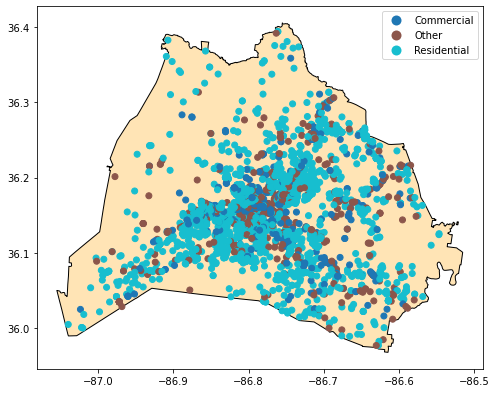

In [52]:
# BLDG PERMIT APPLICATIONS/SUBSET 
# To confirm that all points are within Davidson County

fig, ax = plt.subplots(figsize = (8,8))
df_dav_border.plot(color = 'moccasin', edgecolor = 'black', ax = ax)   # Shows county boarder
df1_applic_geo.plot(column = 'category', ax = ax, legend = True)

In [53]:
# BLDG PERMIT APPLICATIONS/SUBSET spatial join with Davidson County 

# 1. What do I want geometry column to be after join (it keeps 1st one)
# 2  Use operation that fits as read left to right "blgd apps that are WITHIN dav border"

# Dropped 193 points that were outside the county (0.6%)

df2_issued_geo = gpd.sjoin(df2_issued_geo, df_dav_border
                   , op = 'within'     # Keeps APPLICATIONS(L) that are WITHIN the BORDER(R)
                  )
print(df2_issued_geo.shape)
df2_issued_geo.head(2)

(29787, 30)


,permit_number,permit_type_descr,permit_subtype_descr,parcel,date_entered,date_issued,construction_cost,address,city,state,...,category,type_subtype,lat,lon,geometry,index_right,area_sq_mi,objectid,shape_area,shape_len
0,2020011399,Building Commercial - Rehab,"General Office, Professional Services",09503002300,2020-02-21,2020-04-24,468115.0,1 BRIDGESTONE PARK,NASHVILLE,TN,...,Commercial,TYPE: Building Commercial - Rehab SUBTYPE: Gen...,36.166469,-86.690332,POINT (-86.69033 36.16647),0,525,4,14641027913.6,686109.334953
1,2018004314,Building Commercial - Rehab,"General Office, Professional Services",09503002300,2018-01-25,2018-03-16,130000.0,1 BRIDGESTONE PARK 100,NASHVILLE,TN,...,Commercial,TYPE: Building Commercial - Rehab SUBTYPE: Gen...,36.166469,-86.690332,POINT (-86.69033 36.16647),0,525,4,14641027913.6,686109.334953


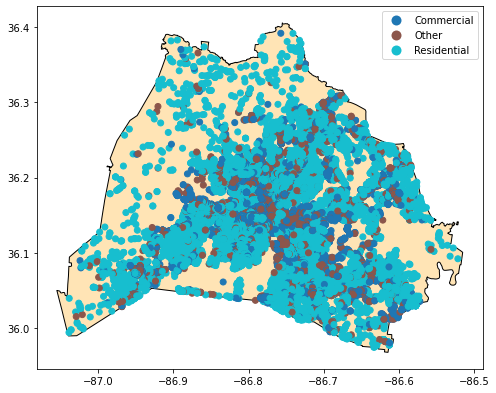

In [54]:
# BLDG PERMIT APPLICATIONS/SUBSET 
# To confirm that all points are within Davidson County

fig, ax = plt.subplots(figsize = (8,8))
df_dav_border.plot(color = 'moccasin', edgecolor = 'black', ax = ax)   # Shows county boarder
df2_issued_geo.plot(column = 'category', ax = ax, legend = True)

## 12. Add Neighborhood Association names

In [55]:
# BLDG PERMIT APPLICATIONS SUBSET - Add Neighborhood Assn name to each row
# Testing spatial join to ensure it's going to work as expected.  CONFIRMED
# Commenting it out to prevent notebook bloat.

#gpd.sjoin(df_na_bound_clean, df1_applic_geo
#          , how = 'right'
#          , op = 'intersects'
#          , lsuffix = 'boundary'  #Suffix to apply to overlapping column names (left GeoDataFrame)
#          , rsuffix = 'apps'      #Suffix to apply to overlapping column names (right GeoDataFrame)
#         )


In [56]:
# BLDG PERMIT APPLICATIONS SUBSET - Add Neighborhood Assn name to each row
# Goal: Get Neighborhood Assoc name on each row where applicable, otherwise NaN
# Reference info: https://geopandas.org/mergingdata.html#spatial-joins

# Overwriting dfx_geo
# Number of columns increased because some N.Assoc's don't have points and have been added w/all NaNs

# pre-generates sindex on df1
df_na_bound_clean.sindex

# polygon df is on left
df1_applic_geo = gpd.sjoin(df_na_bound_clean, df1_applic_geo
                           , how = 'right'
                           , op = 'intersects'
                           , lsuffix = 'boundary'  #Suffix to apply to overlapping column names (left GeoDataFrame)
                           , rsuffix = 'apps'      #Suffix to apply to overlapping column names (right GeoDataFrame)
                          ).reset_index(drop = True)

# new df added anohter index column. Not sure why, but this drops it.
df1_applic_geo = df1_applic_geo.drop(columns = ['index_boundary'])   

print(df1_applic_geo.shape)
df1_applic_geo.head(2)

(2803, 30)


,name,permit_number,permit_type_descr,permit_subtype_descr,parcel,date_entered,date_issued,construction_cost,address,city,...,category,type_subtype,lat,lon,geometry,index_right,area_sq_mi,objectid,shape_area,shape_len
0,Urban Residents,T2017035948,Building Use & Occupancy,"Tents, Stages",09306406200,2017-06-01,NaN,2000.0,1 SYMPHONY PL,NASHVILLE,...,Other,"TYPE: Building Use & Occupancy SUBTYPE: Tents,...",36.160351,-86.775582,POINT (-86.77558 36.16035),0,525,4,14641027913.6,686109.334953
1,Avalon,T2018030936,Building Use & Occupancy,"Tents, Stages",11716016300,2018-05-30,NaN,1200.0,1 UNIVERSITY PARK DR,NASHVILLE,...,Other,"TYPE: Building Use & Occupancy SUBTYPE: Tents,...",36.105624,-86.800012,POINT (-86.80001 36.10562),0,525,4,14641027913.6,686109.334953


In [57]:
# BLDG PERMITS ISSUED SUBSET - Add Neighborhood Assn name to each row
# Testing spatial join to ensure it's going to work as expected.  CONFIRMED
# Commenting it out to prevent notebook bloat.

#gpd.sjoin(df_na_bound_clean, df2_issued_geo
#         , how = 'right'
#         , op = 'intersects'
#         , lsuffix = 'boundary'  #Suffix to apply to overlapping column names (left GeoDataFrame)
#         , rsuffix = 'apps'      #Suffix to apply to overlapping column names (right GeoDataFrame)
#        )

In [58]:
# BLDG PERMITS ISSUED SUBSET - Add Neighborhood Assn name to each row
# Goal: Get Neighborhood Assoc name on each row where applicable, otherwise NaN
# Reference info: https://geopandas.org/mergingdata.html#spatial-joins

# Overwriting dfx_geo
# Number of columns increased because some N.Assoc's don't have points and have been added w/all NaNs

# pre-generates sindex on df1
df_na_bound_clean.sindex

# polygon df is on left
df2_issued_geo = gpd.sjoin(df_na_bound_clean, df2_issued_geo
                           , how = 'right'
                           , op = 'intersects'
                           , lsuffix = 'boundary'  #Suffix to apply to overlapping column names (left GeoDataFrame)
                           , rsuffix = 'apps'      #Suffix to apply to overlapping column names (right GeoDataFrame)
                          ).reset_index(drop = True)

# new df added anohter index column. Not sure why, but this drops it.
df2_issued_geo = df2_issued_geo.drop(columns = ['index_boundary'])   

print(df2_issued_geo.shape)
df2_issued_geo.head(2)

(29931, 31)


,name,permit_number,permit_type_descr,permit_subtype_descr,parcel,date_entered,date_issued,construction_cost,address,city,...,category,type_subtype,lat,lon,geometry,index_right,area_sq_mi,objectid,shape_area,shape_len
0,Chestnut Hill (TAG),2018008573,Building Residential - New,Single Family Residence,10504003100,2018-02-14,2018-02-16,189815.0,1 CLAIBORNE ST,NASHVILLE,...,Residential,TYPE: Building Residential - New SUBTYPE: Sing...,36.146432,-86.761511,POINT (-86.76151 36.14643),0,525,4,14641027913.6,686109.334953
1,Brentwood Downs,2018002099,Building Commercial - Fire Damage,"Multifamily, Tri-Plex, Quad, Apartments",16100005700,2018-01-11,2018-02-22,959470.0,1 DERBY TRCE,NASHVILLE,...,Commercial,TYPE: Building Commercial - Fire Damage SUBTYP...,36.042517,-86.738905,POINT (-86.73891 36.04252),0,525,4,14641027913.6,686109.334953


## 13.  Add column to each df for "Application" and "Issued", respectively

In [60]:
df1_applic_geo['applic_issued'] = 'Application'
df1_applic_geo.head(2)

,name,permit_number,permit_type_descr,permit_subtype_descr,parcel,date_entered,date_issued,construction_cost,address,city,...,type_subtype,lat,lon,geometry,index_right,area_sq_mi,objectid,shape_area,shape_len,applic_issued
0,Urban Residents,T2017035948,Building Use & Occupancy,"Tents, Stages",09306406200,2017-06-01,NaN,2000.0,1 SYMPHONY PL,NASHVILLE,...,"TYPE: Building Use & Occupancy SUBTYPE: Tents,...",36.160351,-86.775582,POINT (-86.77558 36.16035),0,525,4,14641027913.6,686109.334953,Application
1,Avalon,T2018030936,Building Use & Occupancy,"Tents, Stages",11716016300,2018-05-30,NaN,1200.0,1 UNIVERSITY PARK DR,NASHVILLE,...,"TYPE: Building Use & Occupancy SUBTYPE: Tents,...",36.105624,-86.800012,POINT (-86.80001 36.10562),0,525,4,14641027913.6,686109.334953,Application


In [61]:
df2_issued_geo['applic_issued'] = 'Issued'
df2_issued_geo.head(2)

,name,permit_number,permit_type_descr,permit_subtype_descr,parcel,date_entered,date_issued,construction_cost,address,city,...,type_subtype,lat,lon,geometry,index_right,area_sq_mi,objectid,shape_area,shape_len,applic_issued
0,Chestnut Hill (TAG),2018008573,Building Residential - New,Single Family Residence,10504003100,2018-02-14,2018-02-16,189815.0,1 CLAIBORNE ST,NASHVILLE,...,TYPE: Building Residential - New SUBTYPE: Sing...,36.146432,-86.761511,POINT (-86.76151 36.14643),0,525,4,14641027913.6,686109.334953,Issued
1,Brentwood Downs,2018002099,Building Commercial - Fire Damage,"Multifamily, Tri-Plex, Quad, Apartments",16100005700,2018-01-11,2018-02-22,959470.0,1 DERBY TRCE,NASHVILLE,...,TYPE: Building Commercial - Fire Damage SUBTYP...,36.042517,-86.738905,POINT (-86.73891 36.04252),0,525,4,14641027913.6,686109.334953,Issued


# 13. Export separate cleaned CSVs for Applications and Issued
- Origianl plan was to merge/join these into a single df to use in Tableau, but that isn't feasibel with this large df that has many different columns in each df.
- NEW APPROACH:
    1. Export full, cleaned dfs for Permit Applications and Permits Issued, separately, to use in the dashboard where I show all of the information in list form.
    2. Create subsets of each with ONLY the columns needed for mapping - with the same columns & names for each df- then concatnate those two dfs to use for maping in Tableau.

In [62]:
df1_applic_geo.to_csv('../data/cleaned_2/applications_for_bldg_permits_cleaned.csv', index = False)
df1_applic_geo.shape

(2803, 31)

In [63]:
df2_issued_geo.to_csv('../data/cleaned_2/issued_bldg_permits_cleaned.csv', index = False)
df2_issued_geo.shape

(29931, 32)

## 14. Create subsets for mapping / concatenating dfs

In [64]:
print("Shape of df1_applic_geo is: ", df1_applic_geo.shape)
print("Shape of df2_issued_geo is: ", df2_issued_geo.shape)

Shape of df1_applic_geo is:  (2803, 31)
Shape of df2_issued_geo is:  (29931, 32)


In [68]:
print("COLUMNS FOR df1_applic_geo: ", df1_applic_geo.info())
print("COLUMNS FOR ddf2_issued_geo: ", df2_issued_geo.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2803 entries, 0 to 2802
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   name                  1407 non-null   object        
 1   permit_number         2803 non-null   object        
 2   permit_type_descr     2803 non-null   object        
 3   permit_subtype_descr  2803 non-null   object        
 4   parcel                2803 non-null   object        
 5   date_entered          2803 non-null   datetime64[ns]
 6   date_issued           0 non-null      float64       
 7   construction_cost     1610 non-null   float64       
 8   address               2803 non-null   object        
 9   city                  2803 non-null   object        
 10  state                 2803 non-null   object        
 11  zip                   2803 non-null   int64         
 12  subdivision_lot       2802 non-null   object        
 13  contact   

In [66]:
df1_applic_geo.head()

,name,permit_number,permit_type_descr,permit_subtype_descr,parcel,date_entered,date_issued,construction_cost,address,city,...,type_subtype,lat,lon,geometry,index_right,area_sq_mi,objectid,shape_area,shape_len,applic_issued
0,Urban Residents,T2017035948,Building Use & Occupancy,"Tents, Stages",09306406200,2017-06-01,NaN,2000.0,1 SYMPHONY PL,NASHVILLE,...,"TYPE: Building Use & Occupancy SUBTYPE: Tents,...",36.160351,-86.775582,POINT (-86.77558 36.16035),0,525,4,14641027913.6,686109.334953,Application
1,Avalon,T2018030936,Building Use & Occupancy,"Tents, Stages",11716016300,2018-05-30,NaN,1200.0,1 UNIVERSITY PARK DR,NASHVILLE,...,"TYPE: Building Use & Occupancy SUBTYPE: Tents,...",36.105624,-86.800012,POINT (-86.80001 36.10562),0,525,4,14641027913.6,686109.334953,Application
2,Neelys Bend,T2019051561,Building Residential - Rehab,Single Family Residence,06300012900,2019-08-27,NaN,20000.0,100 PINEYWOOD ACRES DR,MADISON,...,TYPE: Building Residential - Rehab SUBTYPE: Si...,36.225744,-86.647669,POINT (-86.64767 36.22574),0,525,4,14641027913.6,686109.334953,Application
3,Edgehill (ONE),T2017065950,Building Demolition Permit,Demolition Permit - Residential,10501050900,2017-10-12,NaN,6500.0,1000 SOUTHSIDE PL,NASHVILLE,...,TYPE: Building Demolition Permit SUBTYPE: Demo...,36.146189,-86.782564,POINT (-86.78256 36.14619),0,525,4,14641027913.6,686109.334953,Application
4,Nations,T2019019414,Building Residential - New,Single Family Residence,091063F00100CO,2019-04-03,NaN,NaN,1001 57TH AVE N,NASHVILLE,...,TYPE: Building Residential - New SUBTYPE: Sing...,36.159446,-86.857549,POINT (-86.85755 36.15945),0,525,4,14641027913.6,686109.334953,Application


In [95]:
df1_applic_geo_to_concat = df1_applic_geo[['name', 'permit_number', 'permit_type_descr'
                                           , 'permit_subtype_descr'
                                           , 'parcel', 'date_entered', 'date_issued'
                                           , 'construction_cost'
                                           , 'address', 'city', 'state', 'zip'
                                           , 'subdivision_lot', 'contact'
                                           , 'permit_type', 'permit_subtype'
                                           , 'ivr_tracking_number', 'purpose'
                                           , 'council_district', 'mapped_location'
                                           , 'category', 'type_subtype'
                                           , 'lat', 'lon', 'geometry', 'applic_issued']]
df1_applic_geo_to_concat.crs = "EPSG:4326"
print(df1_applic_geo_to_concat.crs)
df1_applic_geo_to_concat.head(2)

EPSG:4326


,name,permit_number,permit_type_descr,permit_subtype_descr,parcel,date_entered,date_issued,construction_cost,address,city,...,ivr_tracking_number,purpose,council_district,mapped_location,category,type_subtype,lat,lon,geometry,applic_issued
0,Urban Residents,T2017035948,Building Use & Occupancy,"Tents, Stages",09306406200,2017-06-01,NaN,2000.0,1 SYMPHONY PL,NASHVILLE,...,3371589,"(2) 40x80 tents, staked. No sidewall. Going up...",19.0,"1 SYMPHONY PL\nNASHVILLE, TN 37201\n(36.160351...",Other,"TYPE: Building Use & Occupancy SUBTYPE: Tents,...",36.160351,-86.775582,POINT (-86.77558 36.16035),Application
1,Avalon,T2018030936,Building Use & Occupancy,"Tents, Stages",11716016300,2018-05-30,NaN,1200.0,1 UNIVERSITY PARK DR,NASHVILLE,...,3518214,40x100 Pole Tent set up on 6/4/18. Taking down...,25.0,"1 UNIVERSITY PARK DR\nNASHVILLE, TN 37204\n(36...",Other,"TYPE: Building Use & Occupancy SUBTYPE: Tents,...",36.105624,-86.800012,POINT (-86.80001 36.10562),Application


In [96]:
df2_issued_geo_to_concat = df2_issued_geo[['name', 'permit_number', 'permit_type_descr'
                                           , 'permit_subtype_descr'
                                           , 'parcel', 'date_entered', 'date_issued'
                                           , 'construction_cost'
                                           , 'address', 'city', 'state', 'zip'
                                           , 'subdivision_lot', 'contact'
                                           , 'permit_type', 'permit_subtype'
                                           , 'ivr_tracking_number', 'purpose'
                                           , 'council_district', 'mapped_location'
                                           , 'category', 'type_subtype'
                                           , 'lat', 'lon', 'geometry', 'applic_issued']]
df2_issued_geo_to_concat.crs = "EPSG:4326"
print(df2_issued_geo_to_concat.crs)
df2_issued_geo_to_concat.head(2)

EPSG:4326


,name,permit_number,permit_type_descr,permit_subtype_descr,parcel,date_entered,date_issued,construction_cost,address,city,...,ivr_tracking_number,purpose,council_district,mapped_location,category,type_subtype,lat,lon,geometry,applic_issued
0,Chestnut Hill (TAG),2018008573,Building Residential - New,Single Family Residence,10504003100,2018-02-14,2018-02-16,189815.0,1 CLAIBORNE ST,NASHVILLE,...,3446788,to construct 1685SF single family residence wi...,17.0,"1 CLAIBORNE ST\nNASHVILLE, TN 37210\n(36.14643...",Residential,TYPE: Building Residential - New SUBTYPE: Sing...,36.146432,-86.761511,POINT (-86.76151 36.14643),Issued
1,Brentwood Downs,2018002099,Building Commercial - Fire Damage,"Multifamily, Tri-Plex, Quad, Apartments",16100005700,2018-01-11,2018-02-22,959470.0,1 DERBY TRCE,NASHVILLE,...,3438234,to conduct repair and renovation to fire damag...,27.0,"1 DERBY TRCE\nNASHVILLE, TN 37211\n(36.042517,...",Commercial,TYPE: Building Commercial - Fire Damage SUBTYP...,36.042517,-86.738905,POINT (-86.73891 36.04252),Issued


## 14. Export

### *To change row truncation, as needed*

In [ ]:
# To get full results that aren't truncated, set to high number (default is 50):
pd.options.display.max_rows = 50
print(pd.options.display.max_rows)